In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, GlobalMaxPooling1D
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf



data = pd.read_excel('../results.xlsx')
data['comment'] = data['comment'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','',regex=True)
label_counts = data["label"].value_counts(normalize=True) * 100
invalid_label_rows = data[~data['label'].astype(str).isin(['0', '1'])]  # 문자열로 변환 후 필터링
#토큰화한거 가지고 ㅗㅇ기기
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)



data_shuffled = data.sample(frac=1, random_state=777).reset_index(drop=True)

# 🔹 텍스트와 라벨 분할
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data_shuffled['comment'], data_shuffled['label'], test_size=0.3, random_state=777
)  # 70% train

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=777
)  # 10% val, 20% test

# 🔹 시퀀스로 변환 (각 데이터셋 별로 처리)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# 🔹 최대 시퀀스 길이 설정 (예: 100)
maxlen = 100

# 🔹 패딩 적용
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

# 🔹 라벨을 NumPy 배열로 변환
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)
print(f"y_train shape: {y_train.shape}")
print(f"y_train[:5]: {y_train[:5]}")


print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")
print(f"Train Labels shape: {y_train.shape}, Validation Labels shape: {y_val.shape}, Test Labels shape: {y_test.shape}")
print(tokenizer.word_index)  # 결과 확인



# ✅ 데이터 변환 (float32로 변환)
x_train = np.array(x_train, dtype=np.int32)
x_val = np.array(x_val, dtype=np.int32)
y_train = np.array(y_train, dtype=np.float32).reshape(-1, 1)
y_val = np.array(y_val, dtype=np.float32).reshape(-1, 1)

# ✅ 모델 정의 (출력 차원 수정)
# 올바른 vocab_size 설정
vocab_size = max(x_train.max(), x_val.max()) + 1
 
embedding_dim = 16
maxlen = 100


model = tf.keras.models.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(100, return_sequences=True)),
    GlobalMaxPooling1D(),  # ✅ LSTM의 출력 차원 줄이기
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # ✅ 이진 분류이므로 sigmoid 사용
])

# ✅ 체크포인트 설정
checkpoint_path = 'best_performed_model.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, 
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# ✅ 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# ✅ 모델 학습
history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    epochs=20, 
    verbose=2
)
model.save("best_performed_model.h5")  # ✅ 모델 전체 저장
m_pred = model.predict(x_test)  # 🔹 테스트 데이터에 대한 예측값
pred = (m_pred > 0.5).astype(int)  # 🔹 확률을 0 또는 1로 변환
true = y_test  # 실제 라벨

# ✅ 예측 결과 출력
print("✅ 예측 결과 확인")
print(f"True labels: {true[:10].flatten()}")  # 🔹 실제 라벨 출력
print(f"Predicted labels: {pred[:10].flatten()}")  # 🔹 예측된 라벨 출력

y_train shape: (83,)
y_train[:5]: [0 1 1 0 0]
Train shape: (83, 100), Validation shape: (12, 100), Test shape: (24, 100)
Train Labels shape: (83,), Validation Labels shape: (12,), Test Labels shape: (24,)
{'<OOV>': 1, '이': 3, '다': 5, '거': 19, '저': 22, '안': 29, '수': 62, '말': 73, '것': 80, '건': 102, '너': 103, '더': 130, '목': 136, '뭐': 150, '왜': 175, '잘': 209, '좀': 229, '싹': 243, '씀': 306, '걍': 307}
Epoch 1/20


c:\Users\gory4\miniforge3\envs\dataenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.66212, saving model to best_performed_model.weights.h5
3/3 - 3s - 941ms/step - accuracy: 0.5783 - loss: 0.6829 - val_accuracy: 0.7500 - val_loss: 0.6621
Epoch 2/20

Epoch 2: val_loss improved from 0.66212 to 0.61369, saving model to best_performed_model.weights.h5
3/3 - 0s - 62ms/step - accuracy: 0.7711 - loss: 0.6460 - val_accuracy: 0.7500 - val_loss: 0.6137
Epoch 3/20

Epoch 3: val_loss improved from 0.61369 to 0.56178, saving model to best_performed_model.weights.h5
3/3 - 0s - 58ms/step - accuracy: 0.7711 - loss: 0.5969 - val_accuracy: 0.7500 - val_loss: 0.5618
Epoch 4/20

Epoch 4: val_loss did not improve from 0.56178
3/3 - 0s - 47ms/step - accuracy: 0.7711 - loss: 0.5364 - val_accuracy: 0.7500 - val_loss: 0.5757
Epoch 5/20

Epoch 5: val_loss did not improve from 0.56178
3/3 - 0s - 48ms/step - accuracy: 0.7711 - loss: 0.5296 - val_accuracy: 0.7500 - val_loss: 0.5672
Epoch 6/20

Epoch 6: val_loss improved from 0.56178 to 0.56099, saving mode

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
✅ 예측 결과 확인
True labels: [0 0 0 0 0 0 1 0 0 0]
Predicted labels: [0 0 0 0 0 0 0 0 0 0]


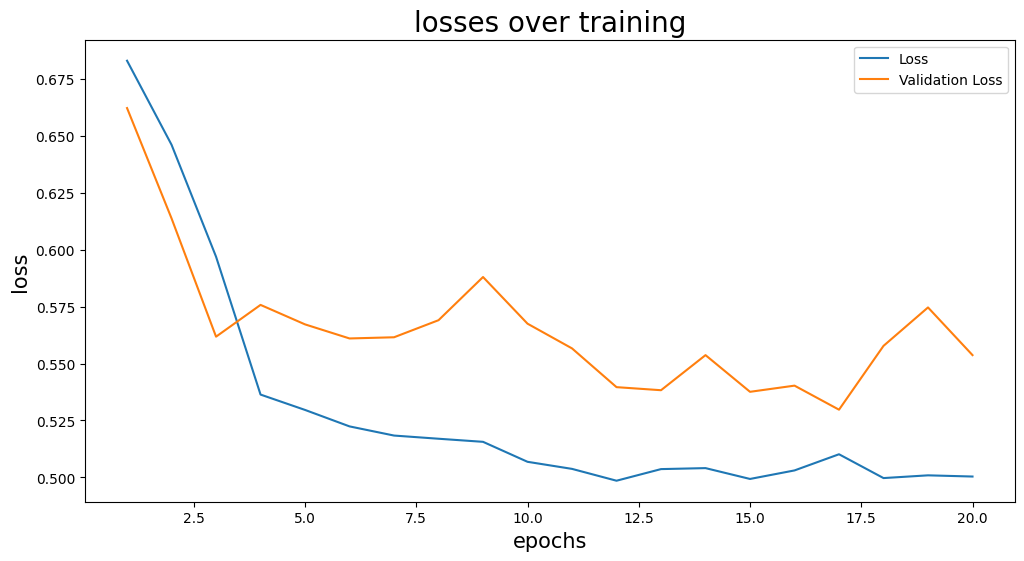

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
model.load_weights(checkpoint_path)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(20)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

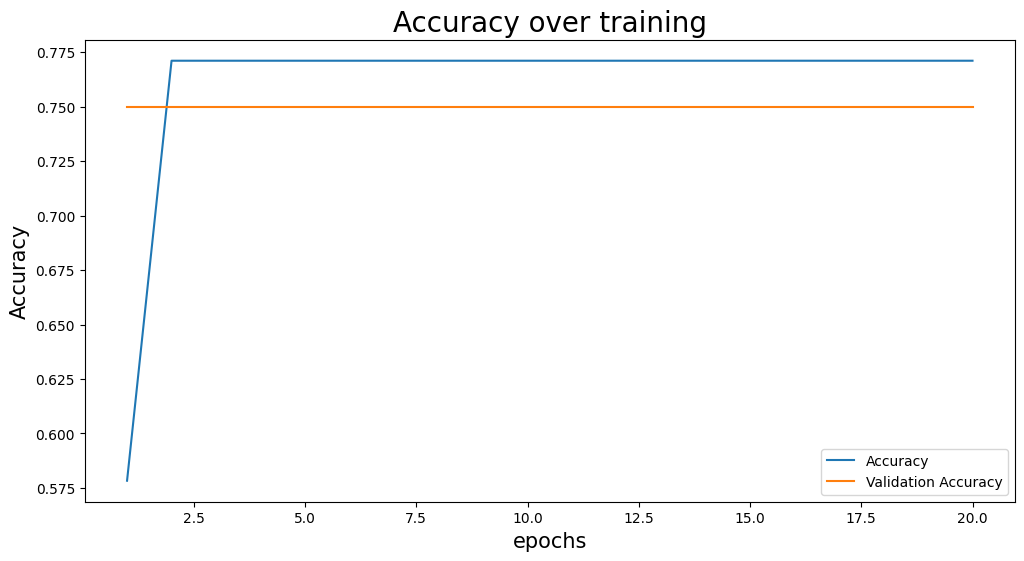

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(20)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()